Cleaned code for modeling the flow of play in a tennis game. The model itself is a **Markov chain** with transition probabilities obtained using **Bayesian logistic regression**. Details of the method can be found in Section 3 of the solution paper.

This notebook focuses on fitting the logistic model to individual states, which we define as all possible scores in a tennis game (e.g., 0-0, 15-0, 0-15, and so on). We use Bayesian estimation for the regression coefficients of our chosen predictors: the intrinsic probability of a server scoring, difference in player fatigue, difference in player Elo, and serve speed. In doing so, we make the crucial assumption that *every state is played identically, no matter its order in the game*.

Although not included in this notebook, sensitivity analyses of both the estimated parameters (i.e., regression coefficients) and the assumption of identical states was performed. Results can be found on page 7 of the solutions paper.

## Preliminaries

In [ ]:
# Replace as needed
%cd /your_directory/

In [68]:
# General use imports
import math
import numpy as np
import pandas as pd

# Plotting
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import xarray as xr
import seaborn as sns
import pylab

# Bayesian modeling
import pymc as pm

# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, brier_score_loss

# Set random seed for reproducibility
import random
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

## Helper functions

In [81]:
def ppc_to_df(ppc):
    """
    Function to convert InferenceData object to Pandas DataFrame.
    """
    observed_data = ppc['observed_data']
    posterior_predictive = ppc['posterior_predictive']

    df_observed_data = observed_data.to_dataframe()

    # Extract predictions
    df_posterior_predictive = posterior_predictive.to_dataframe()
    df_posterior_probs = df_posterior_predictive.groupby('chain').mean()
    df_posterior_probs = df_posterior_predictive.groupby('y_dim_2').mean()
    df_posterior_probs['y_pred'] = df_posterior_probs['y'].apply(lambda x: 1 if x >= 0.5 else 0)

    return df_observed_data, df_posterior_probs

def plot_distributions(samples, sample_col: str,
                      mu: float, sigma: float):
    """
    Plot the distribution using the samples for a single predictor.
    """
    df_samples = samples.to_dataframe()
    plt.figure(figsize=(3, 3))

    # Prior distribution
    x = np.linspace(-10, 10, 2000)
    y = norm.pdf(x, loc=-mu, scale=sigma)
    sns.lineplot(x=x, y=y, label='Prior')

    # Posterior distribution
    sns.kdeplot(data=df_samples[sample_col], color='skyblue', label='Posterior')

    plt.title(f'Prior and posterior distributions for {sample_col}')
    plt.xlabel('Coefficient Value')
    plt.legend()
    plt.show

def single_prediction(attribute_set, intercept_samples, fatigue_samples,
                      elo_samples, speed_samples):
    """
    Make a prediction on a single set or predictors using posterior samples.
    """
    # Compute predictions for each set of parameter samples
    predictions = []
    for i in range(len(intercept_samples)):
        linear_combination = (
            intercept_samples[i] +
            fatigue_samples[i] * attribute_set[0] +
            elo_samples[i] * attribute_set[1] +
            speed_samples[i] * attribute_set[2]
        )
        probability = 1 / (1 + np.exp(-linear_combination))
        predictions.append(probability)

    # plt.hist(predictions, bins=30)
    # plt.show()
    return np.mean(predictions), np.std(predictions)

    return np.mean(sampled_probabilities), np.std(sampled_probabilities)

def get_predictions(X, intercept_samples, fatigue_samples,
                    elo_samples, speed_samples):
    """
    Get predictions on a list of different inputs.
    """
    all_probs = []
    all_uncertainties = []
    for row in X:
        mean, std = single_prediction(row, intercept_samples, fatigue_samples,
                                      elo_samples, speed_samples)
        all_probs.append(mean)
        all_uncertainties.append(std)
    return all_probs, all_uncertainties

def evaluate_predictions(model_name, y_test, y_prob, y_pred):
    print('Model:', model_name)
    print('    Accuracy:', accuracy_score(y_test, y_pred))
    print('    Brier score:', brier_score_loss(y_test, y_prob))
    print()

## Import data

In [16]:
df_states = pd.read_excel('data_states_standardized.xlsx', index_col=0)
df_states.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,return_depth,p1_elo,p2_elo,elo_diff,elo_normalized,fatigue_diff,fatigue_stdz,elo_stdz,serve_diff,serve_stdz
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,ND,2168.9,1838.6,330.3,0.913055,-1.840000,-0.073387,0.83388,-20,-0.465116
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,ND,2168.9,1838.6,330.3,0.913055,-1.840508,-0.073407,0.83388,3,0.069767
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,D,2168.9,1838.6,330.3,0.913055,-3.274002,-0.130581,0.83388,5,0.116279
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,D,2168.9,1838.6,330.3,0.913055,-8.841849,-0.352651,0.83388,15,0.348837
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,NaN,2168.9,1838.6,330.3,0.913055,-6.994364,-0.278965,0.83388,-3,-0.069767


In [19]:
X_states_cols = ['fatigue_stdz', 'elo_stdz', 'serve_stdz']
y_states_col = 'point_victor'

In [34]:
# Make train/test split,
# Modify y column to have 0 when serving player did NOT score

X_states_train, X_states_test, y_states_train, y_states_test = train_test_split(
    df_states[X_states_cols], (df_states[y_states_col].replace(2, 0)),
    test_size=0.1,
    random_state=SEED
)

# Convert to NumPy arrays
X = X_states_train.values
X_test = X_states_test.values
y = y_states_train.values
y_test = y_states_test.values

print('X train shape:', X_states_train.shape)
print('y train shape:', y_states_train.shape)
print('X test shape:', X_states_test.shape)
print('y test shape:', y_states_test.shape)

X train shape: (6555, 3)
y train shape: (6555,)
X test shape: (729, 3)
y test shape: (729,)


## Fitting the Bayesian model

We assume that each predictor has a Normal distribution, then use a mixture of literature review and intuition to obtain parameters for the priors. In particular, the probability that the server wins the point is well-known to be 0.69, so our "baseline" intercept is taken from the corresponding log-odds. The intercept represents our prediction when all other coefficients are 0 (i.e., we have no information about the fatigue, Elo, and speed predictors).

In [54]:
# Prior distributions
mu_intercept = 0.619
sigma_intercept = 0.12
mu_fatigue = -1.115
sigma_fatigue = 0.25
mu_elo = 4.464
sigma_elo = 1.0
mu_speed = 1.847
sigma_speed = 0.37

In [35]:
with pm.Model() as model:
    # Define priors for coefficients
    intercept = pm.Normal('Intercept', mu=mu_intercept, sigma=sigma_intercept)
    prior_fatigue = pm.Normal('B_fatigue', mu=mu_fatigue, sigma=sigma_fatigue)
    prior_elo = pm.Normal('B_elo', mu=mu_elo, sigma=sigma_elo)
    prior_speed = pm.Normal('B_speed', mu=mu_speed, sigma=sigma_speed)

    # Linear model
    linear_combination = intercept + prior_fatigue * X[:, 0] + prior_elo * X[:, 1] + prior_speed * X[:, 2]

    # Convert to probability
    probability = pm.math.sigmoid(linear_combination)

    # Likelihood with Bernoulli distribution
    likelihood = pm.Bernoulli('y', p=probability, observed=y)

    # Sample from the prior distribution
    trace = pm.sample(2000, tune=1000, cores=1)

In [36]:
pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.788,0.027,0.735,0.835,0.000,0.000,5703.0,3870.0,1.0
B_fatigue,-0.600,0.212,-0.991,-0.210,0.003,0.002,5760.0,3089.0,1.0
B_elo,0.327,0.047,0.236,0.415,0.001,0.000,6455.0,3474.0,1.0
B_speed,1.132,0.091,0.963,1.304,0.001,0.001,5482.0,3092.0,1.0


In [37]:
# Extract parameter estimates from the trace
intercept_samples = trace.posterior['Intercept']
fatigue_samples = trace.posterior['B_fatigue']
elo_samples = trace.posterior['B_elo']
speed_samples = trace.posterior['B_speed']

To examine how our priors have been updated after seeing real data, we plot the prior and posterior distributions for each predictor.

<img src='https://i.imgur.com/HH9UTZp.png' align='center'>




In [ ]:
plot_distributions(intercept_samples, 'Intercept', mu_intercept, sigma_intercept)
plot_distributions(fatigue_samples, 'B_fatigue', mu_fatigue, sigma_fatigue)
plot_distributions(elo_samples, 'B_elo', mu_elo, sigma_elo)
plot_distributions(speed_samples, 'B_speed', mu_speed, sigma_speed)

## Posterior predictive checks

While the four posterior distributions represent uncertainties in corresponding parameter (i.e., coefficient) estimates after observing the data, the posterior *predictive* distribution is a single distribution for data generated by the model using samples from the posterior distributions. That is, the posterior predictive distribution is obtained by simulating the *data-generating process*.

In [56]:
with model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=SEED)

In [57]:
df_observed, df_posterior_probs = ppc_to_df(ppc)

We can visualize our model's error using a confusion matrix. In general, we find that our model has signficantly more false positives, meaning it errs on the side of predicting the server to score.

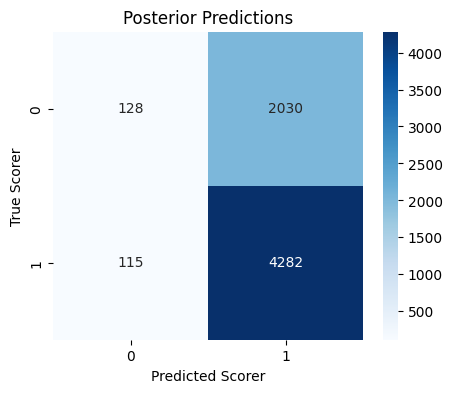

In [59]:
plt.figure(figsize=(5,4))

# Calculate confusion matrix
conf_matrix = confusion_matrix(df_observed['y'], df_posterior_probs['y_pred'])

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Scorer')
plt.ylabel('True Scorer')
plt.title('Posterior Predictions')
plt.show()

## Making predictions on new data

To complete our error analysis, we evaluate the model using our reserved test set. To extract a single point prediction from the coefficient posteriors, we take the average of the predicted probabilities from each posterior sample. We use a threshold of 0.5 for our final binary prediction, meaning probabilities of 0.5 or greater will return the server scoring the next point.

In [72]:
state_probs, state_uncertainties = get_predictions(X_test, intercept_samples,
                                                   fatigue_samples, elo_samples, speed_samples)
state_preds = [0 if p < 0.5 else 1 for p in state_probs]

In [77]:
# Use probability of server scoring from literature
baseline = 0.6876
baseline_probs = []
baseline_preds = []
for i in range(len(state_preds)):
    baseline_probs.append(baseline)
    baseline_preds.append(1)

Again, we can visualize the confusion matrix.

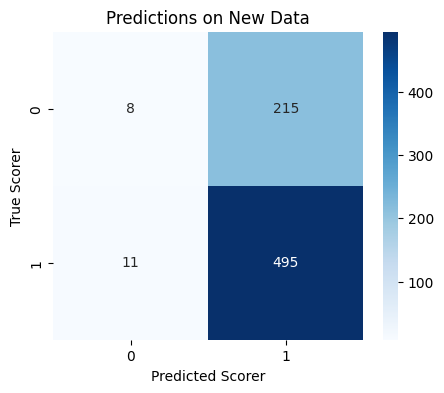

In [84]:
plt.figure(figsize=(5, 4))

cm = confusion_matrix(y_test, state_preds)
# Create a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Scorer')
plt.ylabel('True Scorer')
plt.title('Predictions on New Data')
plt.show()

The **Brier score** is a measurement of the error of a *probability* that offers more nuance than the **accuracy score** for a final classification. We see that our model performs similarly to the baseline model, which predicts the server winning each time, for both metrics. This suggests that---based on evidence from our dataset---fatigue, Elo, and serving speed have little effect on winning points.

In [83]:
evaluate_predictions('Game flow model', y_test, state_probs, state_preds)
evaluate_predictions('Baseline', y_test, baseline_probs, baseline_preds)

Model: Game flow model
    Accuracy: 0.6899862825788752
    Brier score: 0.20874138736514758

Model: Baseline
    Accuracy: 0.6941015089163237
    Brier score: 0.21236687385459532



## Analyzing the flow of play for sample games

See page 9 of the solution paper for analysis.

### Game 1: Server wins

In [87]:
# 2023-wimbledon-1404, set 2 game 4
df_game1 = df_states.copy().iloc[1825:1833]
df_game1 = df_game1.reset_index(drop=True)
df_game1

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,return_depth,p1_elo,p2_elo,elo_diff,elo_normalized,fatigue_diff,fatigue_stdz,elo_stdz,serve_diff,serve_stdz
0,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:25:49,1,8,44,0,0,3,...,D,1762.4,2038.0,-275.6,0.112447,0.259257,0.010340,-0.695784,-13,-0.302326
1,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:26:21,1,8,45,0,0,3,...,D,1762.4,2038.0,-275.6,0.112447,0.176952,0.007058,-0.695784,-24,-0.558140
2,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:27:01,1,8,46,0,0,3,...,D,1762.4,2038.0,-275.6,0.112447,0.168216,0.006709,-0.695784,-12,-0.279070
3,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:27:46,1,8,47,0,0,3,...,D,1762.4,2038.0,-275.6,0.112447,-0.614412,-0.024505,-0.695784,-22,-0.511628
4,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:28:39,1,8,48,0,0,3,...,ND,1762.4,2038.0,-275.6,0.112447,-0.805003,-0.032107,-0.695784,-17,-0.395349
5,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:29:31,1,8,49,0,0,3,...,ND,1762.4,2038.0,-275.6,0.112447,-0.946825,-0.037763,-0.695784,7,0.162791
6,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:30:11,1,8,50,0,0,3,...,D,1762.4,2038.0,-275.6,0.112447,-0.970801,-0.038720,-0.695784,9,0.209302
7,2023-wimbledon-1308,Laslo Djere,Stefanos Tsitsipas,00:30:36,1,8,51,0,0,3,...,NaN,1762.4,2038.0,-275.6,0.112447,-0.939801,-0.037483,-0.695784,-1,-0.023256


In [88]:
# Look at the score states
df_game1[['p1_score', 'p2_score']]

,p1_score,p2_score
0,0,0
1,15,0
2,15,15
3,30,15
4,30,30
5,30,40
6,40,40
7,AD,40


In [95]:
df_game1_X = df_game1[X_states_cols].values
df_game1_y = df_game1[y_states_col].replace(2,0).values

In [96]:
game1_probs, game1_uncertainties = get_predictions(
    df_game1_X, intercept_samples, fatigue_samples, elo_samples, speed_samples
)

In [97]:
game1_probs

[0.5527354702769673,
 0.48108675875926316,
 0.5597687593978796,
 0.4989588043265319,
 0.5329350700426396,
 0.682832064959204,
 0.6942318309920779,
 0.6355745823928821]

In [99]:
game1_preds = [0 if p < 0.5 else 1 for p in game1_probs]
game1_preds

[1, 0, 1, 0, 1, 1, 1, 1]

In [101]:
evaluate_predictions('Server wins', df_game1_y, game1_probs, game1_preds)

Model: Server wins
    Accuracy: 0.875
    Brier score: 0.18564610108685983



### Game 2: Server loses

In [104]:
df_game2 = df_states.iloc[3126:3131]
df_game2 = df_game2.reset_index(drop=True)
df_game2

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,return_depth,p1_elo,p2_elo,elo_diff,elo_normalized,fatigue_diff,fatigue_stdz,elo_stdz,serve_diff,serve_stdz
0,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:47:53,3,5,179,1,1,1,...,ND,2011.4,1769.7,241.7,0.795983,-1.277920,-0.050969,0.610199,-28,-0.651163
1,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:48:22,3,5,180,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.384332,-0.055213,0.610199,-27,-0.627907
2,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:48:50,3,5,181,1,1,1,...,ND,2011.4,1769.7,241.7,0.795983,-1.534606,-0.061207,0.610199,-10,-0.232558
3,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:49:08,3,5,182,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.573548,-0.062760,0.610199,-24,-0.558140
4,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:49:52,3,5,183,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.634051,-0.065173,0.610199,-1,-0.023256


In [105]:
# Look at the score states
df_game2[['p1_score', 'p2_score']]

,p1_score,p2_score
0,0,0
1,0,15
2,0,30
3,15,30
4,15,40


In [106]:
df_game2_X = df_game2[X_states_cols].values
df_game2_y = df_game2[y_states_col].replace(2,0).values

game2_probs, game2_uncertainties = get_predictions(
    df_game2_X, intercept_samples, fatigue_samples, elo_samples, speed_samples
)

In [107]:
game2_probs

[0.5698251446473016,
 0.5768834087686914,
 0.6815860986391394,
 0.5971156942740669,
 0.7311193636942835]

In [108]:
game2_preds = [0 if p < 0.5 else 1 for p in game2_probs]
game2_preds

[1, 1, 1, 1, 1]

In [109]:
evaluate_predictions('Server wins', df_game2_y, game2_probs, game2_preds)

Model: Server wins
    Accuracy: 0.2
    Brier score: 0.3299930503363764



### Game 3: Server wins even more easily

In [110]:
df_game3 = df_states.iloc[3126:3131]
df_game3 = df_game3.reset_index(drop=True)
df_game3

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,return_depth,p1_elo,p2_elo,elo_diff,elo_normalized,fatigue_diff,fatigue_stdz,elo_stdz,serve_diff,serve_stdz
0,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:47:53,3,5,179,1,1,1,...,ND,2011.4,1769.7,241.7,0.795983,-1.277920,-0.050969,0.610199,-28,-0.651163
1,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:48:22,3,5,180,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.384332,-0.055213,0.610199,-27,-0.627907
2,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:48:50,3,5,181,1,1,1,...,ND,2011.4,1769.7,241.7,0.795983,-1.534606,-0.061207,0.610199,-10,-0.232558
3,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:49:08,3,5,182,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.573548,-0.062760,0.610199,-24,-0.558140
4,2023-wimbledon-1313,Andrey Rublev,David Goffin,01:49:52,3,5,183,1,1,1,...,D,2011.4,1769.7,241.7,0.795983,-1.634051,-0.065173,0.610199,-1,-0.023256


In [111]:
# Look at the score states
df_game3[['p1_score', 'p2_score']]

,p1_score,p2_score
0,0,0
1,0,15
2,0,30
3,15,30
4,15,40


In [112]:
df_game3_X = df_game3[X_states_cols].values
df_game3_y = df_game3[y_states_col].replace(2,0).values

game3_probs, game3_uncertainties = get_predictions(
    df_game3_X, intercept_samples, fatigue_samples, elo_samples, speed_samples
)

In [113]:
game3_probs

[0.5698251446473016,
 0.5768834087686914,
 0.6815860986391394,
 0.5971156942740669,
 0.7311193636942835]

In [114]:
game3_preds = [0 if p < 0.5 else 1 for p in game3_probs]
game3_preds

[1, 1, 1, 1, 1]

In [115]:
evaluate_predictions('Server wins', df_game3_y, game3_probs, game3_preds)

Model: Server wins
    Accuracy: 0.2
    Brier score: 0.3299930503363764

